# Negative
This is largely the same as /Positive, but with a different gold label and values assigned in LFs inverted

### Loading texts into a Database

Firstly, initialise the Snorkel Session

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

Then, define the candidate subclass. The ['adjective'] means that the candidate consists of one span named adjective. As snorkel can be used for relation extraction, the examples in snorkel make a list of 2 elements (e.g. ['person1', 'person2']).  
NOTE: Making it just one element meant that  a change in LSTM training needed to be introduced  

In [2]:
from snorkel.models import candidate_subclass

Sentiment = candidate_subclass('Sentiment', ['adjective'])

Read the reviews file by file from given directory. All files are at this parsed by spacy, so any previous pre-processing is not neccessary.

In [3]:
from snorkel.parser import TextDocPreprocessor

from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

from snorkel.models import Document, Sentence

n_docs = 500
doc_preprocessor = TextDocPreprocessor('./data/reviews')



corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor, count=n_docs)

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 14.5 s, sys: 253 ms, total: 14.7 s
Wall time: 14.9 s
('Documents:', 500)
('Sentences:', 5497)


### Candidate matcher

In this task we want to match all adjectives in the text as candidates. In order to achieve that I needed to add a small class to snorkel called AdjectiveMatcher. It takes adavantage of the spacy pre-processsing performed on the inputs and matcches adjectives as candidates.

In [5]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import DictionaryMatch, RegexMatchEach, AdjectiveMatcher

#Read the list of adjectives from a file - no longer used with AdjectiveMatcher
candlist = []
'''
with open('./data/alllist.txt', 'r') as alist:
    for line in alist:
        word = line.strip()
        candlist.append(word)
'''
ngrams         = Ngrams(n_max=1)
#word_matcher = DictionaryMatch(d=candlist)
#word_matcher = RegexMatchEach(rgx=r'([A-Za-z]+)/JJ')
word_matcher = AdjectiveMatcher(longest_match_only=True)
cand_extractor = CandidateExtractor(Sentiment, [ngrams], [word_matcher])

### Split the data into training, development and test

In [6]:
from snorkel.models import Document

docs = session.query(Document).order_by(Document.name).all()

train_sents = set()
dev_sents   = set()
test_sents  = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
        if i % 9 == 7:
            dev_sents.add(s)
        elif i % 9 == 8:
            test_sents.add(s)
        else:
            train_sents.add(s)

In [7]:
%%time
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
    cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Sentiment).filter(Sentiment.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 7542)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 1154)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 899)
CPU times: user 12.1 s, sys: 182 ms, total: 12.3 s
Wall time: 12.4 s


### Preview the candidates in snorkel viewer

This is just not neccassary for the working of the classification, but helpful when developing to see if things work correctly.

In [8]:
import snorkel.viewer as sv
sv.SentenceNgramViewer(session.query(Sentiment).filter(Sentiment.split == 1)
                       , session)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzMwNiwgNzA0LCA3NDZdLCBbNzQsIDMwN10sIFsyMjRdXSwgW1s4OSwgMjcyXSwgWzM2OV0sIFs3MTJdXSwgW1sxOThdLCBbODE5XSwgWzg2LCDigKY=


## Defining the labelling functions (LFs)

In [9]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)
from nltk.corpus import wordnet as wn
import gensim

# Load Google's pre-trained Word2Vec model.
trained_model = gensim.models.KeyedVectors.load_word2vec_format('~/models/GoogleNews-vectors-negative300.bin', binary=True)  

In [10]:
def LF_pos_neg_sim(c):
    word = (c.adjective.get_span().encode('utf-8'))
    try:
        pos = trained_model.similarity(word, 'positive')
        neg = trained_model.similarity(word, 'negative')
    except:
        return 0
    if pos > neg:
        return -1
    else:
        return 1

def LF_good_bad_sim(c):
    word = (c.adjective.get_span().encode('utf-8'))
    try:
        good = trained_model.similarity(word, 'good')
        bad = trained_model.similarity(word, 'bad')
    except:
        return 0
    if good > bad:
        return -1
    else:
        return 1
    
def LF_happy_sad_sim(c):
    word = (c.adjective.get_span().encode('utf-8'))
    try:
        happy = trained_model.similarity(word, 'happy')
        sad = trained_model.similarity(word, 'sad')
    except:
        return 0
    if happy > sad:
        return -1
    else:
        return 1

def LF_strong_weak_sim(c):
    word = (c.adjective.get_span().encode('utf-8'))
    try:
        strong = trained_model.similarity(word, 'strong')
        weak = trained_model.similarity(word, 'weak')
    except:
        return 0
    if strong > weak:
        return -1
    else:
        return 1

#### Checking if an LF works
Test the working of a labelling function - for instance, LF_pos_neg_sim is tested here. This step is here as halper for developing LFs, can be skipped when we just want to run the full classification.

In [11]:
labeled = []
for c in session.query(Sentiment).all():
    if LF_pos_neg_sim(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))

('Number labeled:', 9310)


In [12]:
import snorkel.viewer as sv
sv.SentenceNgramViewer(labeled, session)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzI1MywgNzE2NiwgNzI4M10sIFszNTk4LCA0MTY5LCA0OTA3XSwgWzM2NjJdXSwgW1syMDE2XSwgWzU5NDZdLCBbNjExMV1dLCBbWzU0NF0sIFvigKY=


Insert the labelling functions that you want to use into a list.

In [14]:
LFs = [
    LF_pos_neg_sim,  LF_good_bad_sim, LF_happy_sad_sim, LF_strong_weak_sim
]

### Load the gold labels from external file

Uses util.py file located in the same directory. Within the util.py file the path to the file with gold annotations is provided.  
NOTE: Label loading code in snorkel is nondestructive, so re-running this cell within the same session won't replace existing labels in the database.

In [15]:
from util import load_external_labels

%time missed = load_external_labels(session, Sentiment, annotator_name='gold', setup='neg')

AnnotatorLabels created: 678
AnnotatorLabels created: 572
CPU times: user 50.4 s, sys: 365 ms, total: 50.7 s
Wall time: 50.9 s


In [16]:
from snorkel.annotations import load_gold_labels


L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [17]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [18]:
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 30.6 s, sys: 139 ms, total: 30.8 s
Wall time: 31.1 s


<7542x4 sparse matrix of type '<type 'numpy.int64'>'
	with 29216 stored elements in Compressed Sparse Row format>

In [19]:
%time L_train = labeler.load_matrix(session, split=0)
L_train

CPU times: user 211 ms, sys: 3.89 ms, total: 215 ms
Wall time: 214 ms


<7542x4 sparse matrix of type '<type 'numpy.int64'>'
	with 29216 stored elements in Compressed Sparse Row format>

In [20]:
L_train.get_candidate(session, 0)

Sentiment(Span("last", sentence=2665, chars=[26,29], words=[6,6]))

In [21]:
L_train.get_key(session, 0)

LabelKey (LF_pos_neg_sim)


* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a *conflicting* non-zero label for.

In [22]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_pos_neg_sim,0,0.968443,0.968443,0.449085
LF_good_bad_sim,1,0.968443,0.968443,0.449085
LF_happy_sad_sim,2,0.968443,0.968443,0.449085
LF_strong_weak_sim,3,0.968443,0.968443,0.449085


## Fitting the Generative Model

In [23]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


#### Insight into the model
Can be skipped if just looking for the final results.

In [24]:
gen_model.weights.lf_accuracy

array([ 1.24106813,  1.50365797,  0.92333271,  1.2374207 ])

In [25]:
train_marginals = gen_model.marginals(L_train)

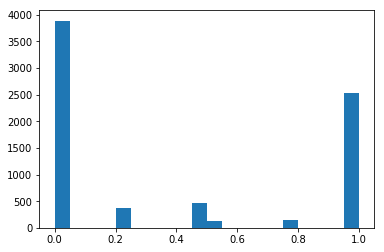

In [26]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [27]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.926762,0.7933,0.940383,0.736111
1,0.948432,0.8261,0.957456,0.783519
2,0.870607,0.7427,0.884954,0.652407
3,0.925029,0.7883,0.938707,0.728889


## Debugging Labelling Functions

Load L_gold_dev for the dev set.

In [28]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



Scores for the dev set.

In [29]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.486
Neg. class accuracy: 0.628
Precision            0.327
Recall               0.486
F1                   0.391
----------------------------------------
TP: 152 | FP: 313 | TN: 528 | FN: 161



In [30]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fp, session)
else:
    sv = None

<IPython.core.display.Javascript object>

In [31]:
sv

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzE4OF0sIFsyMywgNzNdLCBbNTNdXSwgW1s2Ml0sIFsyMDldLCBbMTU0XV0sIFtbOTldLCBbMjQzXSwgWzE2XV0sIFtbNCwgMjU2XSwgWzE3NCzigKY=


In [32]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_pos_neg_sim,0,0.980936,0.980936,0.433276,165,92,148,273,0.646018,0.923418
LF_good_bad_sim,1,0.980936,0.980936,0.433276,166,76,147,289,0.671091,0.956120
LF_happy_sad_sim,2,0.980936,0.980936,0.433276,181,125,132,240,0.620944,0.862562
LF_strong_weak_sim,3,0.980936,0.980936,0.433276,166,101,147,264,0.634218,0.926982


In [33]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 7542 marginals
CPU times: user 4.23 s, sys: 4.1 ms, total: 4.24 s
Wall time: 4.23 s


## Train the Discriminative Model

In [34]:
from snorkel.annotations import load_marginals

train_marginals = load_marginals(session, split=0)

In [35]:
train_cands = session.query(Sentiment).filter(Sentiment.split == 0).order_by(Sentiment.id).all()
dev_cands   = session.query(Sentiment).filter(Sentiment.split == 1).order_by(Sentiment.id).all()
test_cands  = session.query(Sentiment).filter(Sentiment.split == 2).order_by(Sentiment.id).all()

In [36]:
from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [37]:
from snorkel.learning.pytorch.rnn import LSTM

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   50,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm = LSTM(n_threads=1)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)



[LSTM] Training model
[LSTM] n_train=7304  #epochs=50  batch size=128
[LSTM] Epoch 1 (12.34s)	Average loss=0.676680	Dev F1=2.98
[LSTM] Epoch 2 (25.46s)	Average loss=0.673577	Dev F1=3.00
[LSTM] Epoch 3 (38.51s)	Average loss=0.666062	Dev F1=10.75
[LSTM] Epoch 4 (51.67s)	Average loss=0.645537	Dev F1=32.45
[LSTM] Epoch 5 (64.51s)	Average loss=0.573220	Dev F1=41.61
[LSTM] Epoch 6 (77.20s)	Average loss=0.480911	Dev F1=37.90
[LSTM] Epoch 7 (89.84s)	Average loss=0.449200	Dev F1=40.65
[LSTM] Epoch 8 (102.54s)	Average loss=0.456024	Dev F1=42.54
[LSTM] Epoch 9 (115.24s)	Average loss=0.686337	Dev F1=36.53
[LSTM] Epoch 10 (126.98s)	Average loss=0.553344	Dev F1=36.65
[LSTM] Epoch 11 (139.64s)	Average loss=0.453379	Dev F1=37.10
[LSTM] Epoch 12 (152.38s)	Average loss=0.362860	Dev F1=36.81
[LSTM] Epoch 13 (165.03s)	Average loss=0.318716	Dev F1=38.81
[LSTM] Epoch 14 (177.48s)	Average loss=0.296887	Dev F1=37.72
[LSTM] Epoch 15 (192.14s)	Average loss=0.276173	Dev F1=38.64
[LSTM] Epoch 16 (206.55s)	Average

## Results

In [38]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.377, Recall: 0.398, F1 Score: 0.387


In [39]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.398
Neg. class accuracy: 0.719
Precision            0.377
Recall               0.398
F1                   0.387
----------------------------------------
TP: 107 | FP: 177 | TN: 453 | FN: 162



In [40]:
lstm.save_marginals(session, test_cands)

Saved 899 marginals
